In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jrandom
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter
import random
from google.colab import files

In [ ]:
n = 100
m = 2
p = 0
const_num = 0  # Number of immovable points (one per net)
min_components_per_net = 2
max_components_per_net = 6
dt = 0.1
max_iterations = 250

In [ ]:
key = jrandom.PRNGKey(42)
points = jrandom.uniform(key, (n, 2), minval=-1.0, maxval=1.0)

import networkx as nx
import numpy as np
import jax.numpy as jnp

def generate_graph(points, n, m, p):
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Assign random weights to nodes
    node_weights = np.random.rand(n)  # or use np.random.randint(low, high, size=n) for integer weights
    for i in range(n):
        G.nodes[i]['weight'] = node_weights[i]

    distances = jnp.sqrt(jnp.sum((points[:, None, :] - points[None, :, :])**2, axis=-1))

    for new_node in range(m, n):
        potential_edges = []
        for existing_node in range(new_node):
            weight = 1 / (distances[new_node, existing_node] + 1e-9)
            potential_edges.append((weight, existing_node))
        potential_edges.sort(reverse=True)

        selected_edges = [edge[1] for edge in potential_edges[:m]]
        G.add_edges_from([(new_node, sel) for sel in selected_edges if new_node != sel])

        for sel in selected_edges:
            neighbors = list(G.neighbors(sel))
            if neighbors and np.random.random() < p:
                closest_neighbor = min(neighbors, key=lambda x: distances[new_node, x])
                if closest_neighbor != new_node:
                    G.add_edge(new_node, closest_neighbor)

    return G, distances


def enforce_component_constraint(G, distances, min_components, max_components):
    nets = list(nx.connected_components(G))
    for net in nets:
        while len(net) < min_components:
            node = random.choice(list(net))
            non_neighbors = [n for n in G.nodes if n not in net and n != node]
            if non_neighbors:
                new_neighbor = random.choice(non_neighbors)
                G.add_edge(node, new_neighbor)
                net = max(nx.connected_components(G), key=len)
        while len(net) > max_components:
            node = random.choice(list(net))
            neighbors = list(G.neighbors(node))
            if neighbors:
                farthest_neighbor = max(neighbors, key=lambda x: distances[node, x])
                G.remove_edge(node, farthest_neighbor)
            net = max(nx.connected_components(G), key=len)
    return G

def connect_isolated_points(G, distances):
    isolated_nodes = list(nx.isolates(G))
    while isolated_nodes:
        for node in isolated_nodes:
            non_isolated_nodes = [n for n in G.nodes if n not in isolated_nodes]
            if non_isolated_nodes:
                closest_node = min(non_isolated_nodes, key=lambda x: distances[node, x])
                G.add_edge(node, closest_node)
        isolated_nodes = list(nx.isolates(G))
    return G

def generate_and_enforce_graph(points, n, m, p, min_components, max_components):
    while True:
        G, distances = generate_graph(points, n, m, p)
        G = enforce_component_constraint(G, distances, min_components, max_components)
        G.remove_edges_from(nx.selfloop_edges(G))
        G = connect_isolated_points(G, distances)
        if not list(nx.isolates(G)):
            break
    return G

def get_immovable_points_idx(G, const_num):
    nets = list(nx.connected_components(G))
    immovable_points_idx = []

    for net in nets:
        immovable_point = random.choice(list(net))
        immovable_points_idx.append(immovable_point)

    return jnp.array(immovable_points_idx)



def mahalanobis_gradient(gradients, A):
    cov_matrix = jnp.cov(gradients.T)
    inv_cov_matrix = jnp.linalg.inv(cov_matrix + jnp.eye(cov_matrix.shape[0]) * 1e-2)
    mahalanobis_grad = jnp.einsum('ij,kj->ki', inv_cov_matrix, gradients)
    return mahalanobis_grad
def loss_function(points, G, r_ref=1.0):
    epsilon = 1e-6
    energy = 0.0
    edges = list(G.edges)

    '''for i, j in edges:
        dx = points[j, 0] - points[i, 0]
        dy = points[j, 1] - points[i, 1]
        dist = jnp.sqrt(dx**2 + dy**2) + epsilon

        q_i = G.nodes[i]["weight"]
        q_j = G.nodes[j]["weight"]

        energy += -q_i * q_j * jnp.log(dist / r_ref)

    edges = list(G.edges)'''
    x_diffs = jnp.abs(jnp.array([points[j, 0] - points[i, 0] for i, j in edges]))
    y_diffs = jnp.abs(jnp.array([points[j, 1] - points[i, 1] for i, j in edges]))

    energy_x = jnp.log(jnp.sum(jnp.exp(x_diffs)**10)) / 10 + jnp.log(jnp.sum(jnp.exp(-x_diffs)**10)) / 10
    energy_y = jnp.log(jnp.sum(jnp.exp(y_diffs)**10)) / 10 + jnp.log(jnp.sum(jnp.exp(-y_diffs)**10)) / 10

    energy += energy_x + energy_y
    return energy

1.2257154


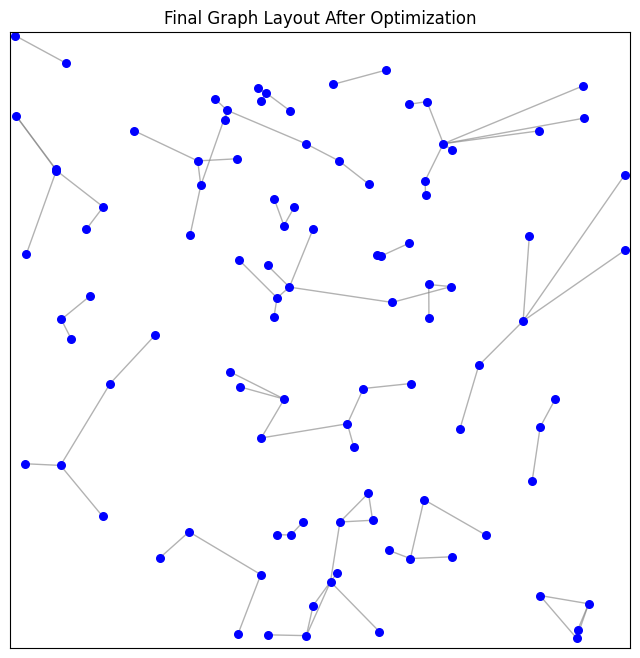

In [ ]:
G = generate_and_enforce_graph(points, n, m, p, min_components_per_net, max_components_per_net)
immovable_points_idx = get_immovable_points_idx(G, const_num)
fig, ax = plt.subplots(figsize=(8, 8))
pos_final = {i: points[i].tolist() for i in G.nodes}
edges = list(G.edges)
x_diffs = jnp.abs(jnp.array([points[j, 0] - points[i, 0] for i, j in edges]))
y_diffs = jnp.abs(jnp.array([points[j, 1] - points[i, 1] for i, j in edges]))

energy_x = jnp.log(jnp.sum(jnp.exp(x_diffs)**10)) / 10
energy_y = jnp.log(jnp.sum(jnp.exp(y_diffs)**10)) / 10
print(energy_x+energy_y)
nx.draw_networkx_nodes(G, pos_final, node_color='blue', node_size=30, ax=ax)
nx.draw_networkx_edges(G, pos_final, edge_color='gray', alpha=0.6, ax=ax)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_title("Final Graph Layout After Optimization")
plt.show()

[[-7.39071285e-03  1.25171617e-02]
 [ 4.24664021e-02  2.13312358e-02]
 [-6.61578551e-02 -2.99644992e-02]
 [-2.94098891e-02  4.70457375e-02]
 [-3.97515804e-01 -1.45428628e-02]
 [-6.32636100e-02  2.38667075e-02]
 [ 1.78602591e-01 -4.98762773e-03]
 [ 2.54139751e-02 -8.85698944e-03]
 [ 1.07518584e-03  9.71643813e-03]
 [ 2.20302567e-02 -3.00943330e-02]
 [ 9.22604185e-03  9.85620171e-03]
 [ 4.26189881e-03 -3.60691473e-02]
 [ 1.82759315e-02  1.57569610e-02]
 [-7.56616984e-03 -4.80656885e-03]
 [ 5.95239038e-03 -1.15011614e-02]
 [-1.19942911e-02  1.18112937e-02]
 [-2.88358014e-02 -1.32434964e-02]
 [ 5.82630262e-02 -1.77161712e-02]
 [ 3.05846948e-02 -2.13081278e-02]
 [-2.17281692e-02 -9.71688889e-04]
 [ 8.30353890e-03 -7.13126408e-03]
 [ 2.01657452e-02  8.52742791e-03]
 [ 3.26524209e-03  2.28867736e-02]
 [ 9.38716345e-04 -1.61882285e-02]
 [-2.34367363e-02  1.32285338e-02]
 [-1.48945563e-02  1.79302022e-02]
 [-2.68347133e-02 -7.09521957e-03]
 [ 3.44735058e-03 -1.79250892e-02]
 [-2.15073302e-02  9

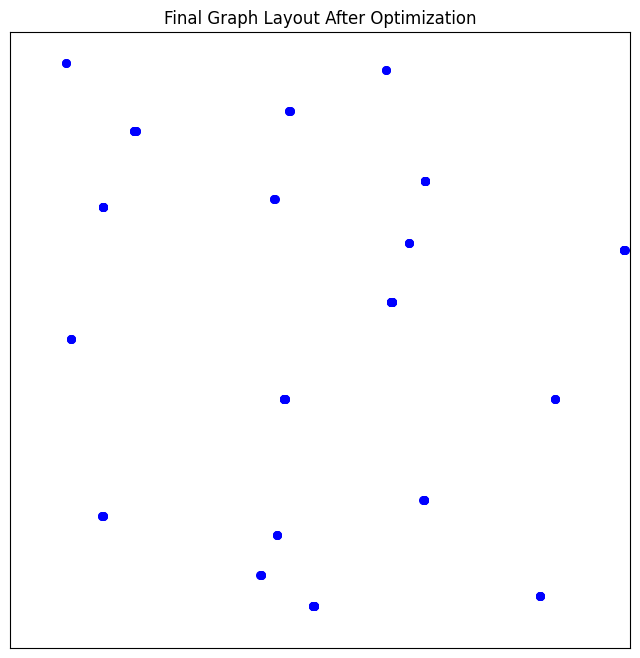

In [ ]:
def simulate_mahalanobis_gradient_descent_final(G, immovable_points_idx, initial_points, dt, max_iterations, A, damping_coefficient=0.1, convergence_threshold=1e-4):
    points = initial_points.copy()
    movable_points_idx = jnp.array([i for i in range(len(points)) if i not in immovable_points_idx])
    velocities = jnp.zeros((movable_points_idx.shape[0], 2))  # Adjust shape to match movable points

    loss_grad = jax.grad(loss_function, argnums=0)
    print(loss_grad(points, G))
    for i in range(max_iterations):
        if i%50==0:
            print(i)
        gradients = loss_grad(points, G)
        mah_gradients = mahalanobis_gradient(gradients, A)

        # Update velocities for movable points only
        velocities = velocities * (1 - damping_coefficient*dt) - dt * mah_gradients[movable_points_idx]
        updated_movable_points = points[movable_points_idx] + velocities * dt
        points = points.at[movable_points_idx].set(updated_movable_points)

        if jnp.all(jnp.linalg.norm(velocities, axis=1) < convergence_threshold):
            break
    edges = list(G.edges)
    x_diffs = jnp.abs(jnp.array([points[j, 0] - points[i, 0] for i, j in edges]))
    y_diffs = jnp.abs(jnp.array([points[j, 1] - points[i, 1] for i, j in edges]))
    energy_x = jnp.log(jnp.sum(jnp.exp(x_diffs)**10)) / 10
    energy_y = jnp.log(jnp.sum(jnp.exp(y_diffs)**10)) / 10
    print(energy_x+energy_y)
    fig, ax = plt.subplots(figsize=(8, 8))
    pos_final = {i: points[i].tolist() for i in G.nodes}
    nx.draw_networkx_nodes(G, pos_final, node_color='blue', node_size=30, ax=ax)
    nx.draw_networkx_edges(G, pos_final, edge_color='gray', alpha=0.6, ax=ax)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title("Final Graph Layout After Optimization")
    return G, pos_final
B = jrandom.normal(key, (2, 2))
A = B.T @ B
G1, pos1 = simulate_mahalanobis_gradient_descent_final(G, immovable_points_idx, points, dt, max_iterations, A, damping_coefficient=0.9)
